# Task 4: Game Title Detection

In this task, we will perform a training process for game title classification by using images. We will use the Image classification model to do this task.

In [24]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import models
from keras import layers
from keras.layers import Input
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.layers import Input
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt


## Step 1: Data Preparation

### Step 1.1: Load label and set filepath

In [25]:
df_train = pd.read_csv('task4/train.csv')
df_val = pd.read_csv('task4/val.csv')

df_train.head()

,id,file_name,label
0,PLY00001,su7tkav.jpg,0
1,PLY00002,shlk51f.jpg,4
2,PLY00003,sbdqvs0.jpg,0
3,PLY00004,s6oe1m9.jpg,2
4,PLY00005,skn51jb.jpg,0


In [26]:
df_train['filepath'] = df_train['file_name'].apply(lambda x : os.path.join('task4/train', x))

df_val['filepath'] = df_val['file_name'].apply(lambda x : os.path.join('task4/val', x))

df_train.head()

,id,file_name,label,filepath
0,PLY00001,su7tkav.jpg,0,task4/train/su7tkav.jpg
1,PLY00002,shlk51f.jpg,4,task4/train/shlk51f.jpg
2,PLY00003,sbdqvs0.jpg,0,task4/train/sbdqvs0.jpg
3,PLY00004,s6oe1m9.jpg,2,task4/train/s6oe1m9.jpg
4,PLY00005,skn51jb.jpg,0,task4/train/skn51jb.jpg


Split validation file for the evaluation part

In [27]:
df_val_split, df_test_split = train_test_split(
    df_val,
    test_size=0.5,           # or 0.2 if you want smaller test set
    stratify=df_val['label'], # keeps class balance
    random_state=42
)

print(len(df_val_split), "validation samples")
print(len(df_test_split), "test samples")

12386 validation samples
12386 test samples


## Step 1.2: Load image

In [28]:
#image properties
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

Preprocess that train and validate data

In [29]:
num_classes = df_train['label'].nunique()

def create_dataset(df, num_classes= num_classes, Image_Size=Image_Size):
    file_paths = df['filepath'].values
    labels = df['label'].values

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, Image_Size)
        image = image / 255.0
        return image, tf.one_hot(label, num_classes)

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

In [30]:
train_ds = create_dataset(df_train)
val_ds = create_dataset(df_val_split)
test_ds = create_dataset(df_test_split)

In [31]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

# Step 2: Set up the model

In [32]:
#neural network
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()
model.add(Input(shape=(Image_Width, Image_Height, Image_Channels)))

model.add(Conv2D(32,(3,3),padding='same',activation='elu',kernel_initializer='he_normal',input_shape=(Image_Width,Image_Height,Image_Channels), name='conv_1'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2, name='max_pool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding='same',activation='elu',kernel_initializer='he_normal', name='conv_2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2,name='max_pool_2'))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),padding='same',activation='elu',kernel_initializer='he_normal', name='conv_3'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2,name='max_pool_3'))
model.add(Dropout(0.25))

model.add(Conv2D(216,(3,3),padding='same',activation='elu',kernel_initializer='he_normal', name='conv_4'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2,name='max_pool_4'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu', name='fully_connect'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax', name='output'))

model.compile(
    loss='CategoricalCrossentropy',
    optimizer='rmsprop',
    metrics=['acc']
)

/home/mahwayji/storage/kmutt pro/kmutt year 3/Machine learning/CPE342-Karena/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_1 (MaxPooling2D)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_2 (MaxPooling2D)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_3 (MaxPooling2D)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 216)    │       249,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 216)    │           864 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_4 (MaxPooling2D)       │ (None, 8, 8, 216)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 216)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connect (Dense)           │ (None, 512)            │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,427,069 (28.33 MB)

 Trainable params: 7,425,165 (28.32 MB)

 Non-trainable params: 1,904 (7.44 KB)

# Step 3: Modeling

In [34]:
epoch = 1

history = model.fit(
    train_ds,
    batch_size = 128,
    epochs=epoch,
    validation_data=val_ds,
)
model.save('baseline_mdel_itr10_data_aug.h5')

986/986 ━━━━━━━━━━━━━━━━━━━━ 1094s 1s/step - acc: 0.5833 - loss: 1.2116 - val_acc: 0.4994 - val_loss: 1.4236


# Step 4: Evaluation

In [35]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    #labels = labels.argmax(axis=1)

    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    # elif channel == 1:
    #     false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    # else:
        # raise ValueError('Must be RGB or gray scale image')

    # Ensure values are in [0,1] or [0,255]
    if false_pred.dtype != np.uint8:
        false_pred = np.clip(false_pred, 0, 255)  # clip out-of-range
        false_pred = false_pred.astype('uint8')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

Last train accuracy: 0.5833069086074829
Last validation accuracy: 0.49943485856056213


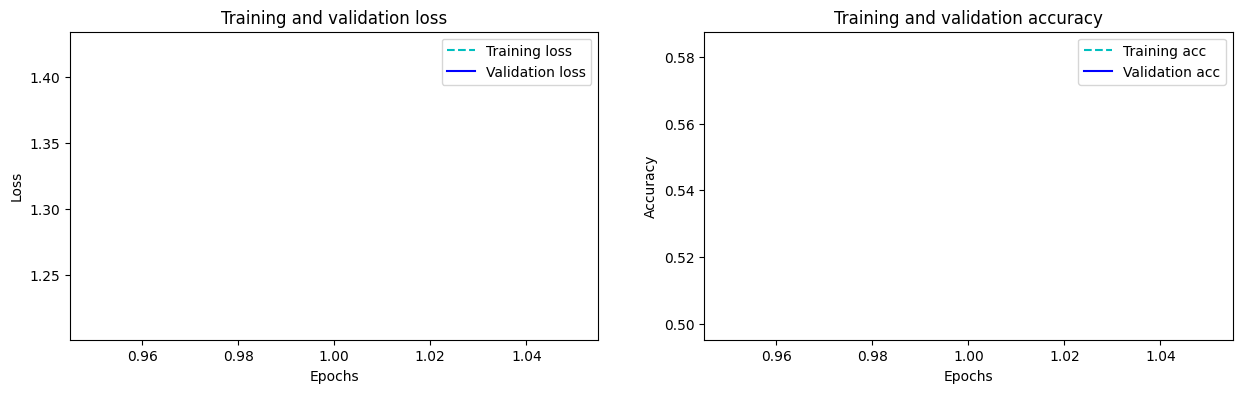

In [36]:
show_result(history)

In [37]:
result = model.evaluate(test_ds)

result

388/388 ━━━━━━━━━━━━━━━━━━━━ 58s 150ms/step - acc: 0.5012 - loss: 1.4272


[1.4271819591522217, 0.5012110471725464]

Separate data and label for the evaluation

In [ ]:
X_test = []
y_test = []

for images, labels in test_ds:
        X_test.append(images.numpy())
        y_test.append(labels.numpy())
        
    
X_test = np.concatenate(X_test, axis = 0)
y_test = np.concatenate(y_test, axis = 0)

In [ ]:
pred_class = model.predict(X_test)

pred_class

In [ ]:
pred_class = evaluation_report
(model, X_test, y_test)

pred_class

In [ ]:
y_test

In [ ]:
show_false_prediction(pred_class, X_test, y_test)